In [1]:
import torch
import torch.nn as nn
from  torch.distributions import Normal
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import math

In [2]:
env = gym.make('Pendulum-v0')

In [3]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print("State Size ",state_size)
print("State information ",env.observation_space)
print("Action size ",action_size)
print("Action information ",env.action_space)

State Size  3
State information  Box(3,)
Action size  1
Action information  Box(1,)


### Watching a Random Agent Play

In [4]:
score  = 0
state = env.reset()
while True:
    action = env.action_space.sample()
    env.render()
    state,reward,done,_ = env.step(action)
    score+=reward
    if done:
        break
print("Score  : ",score)

Score  :  -897.9103728575549


## 2. Building the Neural Network

In [5]:
class Actor(nn.Module):
    def __init__(self,input_size,output_size,std=0.1):
        super().__init__()
        
        self.mean = nn.Sequential(nn.Linear(input_size,64),
                                  nn.ReLU(),
                                  nn.Linear(64,32),
                                  nn.ReLU(),
                                  nn.Linear(32,output_size),
                                  nn.Tanh())
        self.log_std = nn.Parameter(torch.ones(1, output_size) * std)
    def forward(self,state):
        state = torch.from_numpy(state).float()
        mu = self.mean(state)
        std  = self.log_std.exp()
        dist = Normal(mu,std)
        return dist

In [6]:
class Critic(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,1)
    def forward(self,state):
        state = torch.from_numpy(state).float()
        x = F.leaky_relu(self.fc1(state))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
actor = Actor(state_size,action_size)
critic = Critic(state_size)
ac_opt = optim.Adam(actor.parameters(),lr=0.0001)
cr_opt = optim.Adam(critic.parameters(),lr=0.0001)

### Hyperparameters

In [8]:
n_episodes = 1000
beta_entropy = 0.001
gamma = 0.9

## A2C Continuos Algorithm

In [9]:
reward_per_ep=[]
for ep in range(1,n_episodes+1):
    score = 0 
    state = env.reset()
    for _ in range(100):
        
        dist = actor(state)
        action = dist.sample().cpu().detach().numpy()[0]
        action = np.clip(action,-1,1)
        next_state,reward,done,_ = env.step(action)
        
        advantage = reward+(1-done)*gamma*critic(next_state) - critic(state).detach()
        critic_loss = 0.5*advantage.pow(2)
        cr_opt.zero_grad()
        critic_loss.backward()
        cr_opt.step()
        action = torch.tensor([action])
        #log_prob = -((action-mean)**2/((2*std**2)+1e-3) + torch.log(torch.sqrt(2*np.pi*std**2)))*advantage.detach()
        log_prob = - dist.log_prob(action) * advantage.detach()
        #entropy = (2*np.pi*np.exp(1)*std**2)**0.5
        entropy = dist.entropy().mean()
        actor_loss = log_prob - beta_entropy*entropy
        ac_opt.zero_grad()
        actor_loss.backward()
        ac_opt.step()
        
        state = next_state
        score+=reward
        
        if done:
            break
    reward_per_ep.append(score)
    print("\rEpisode {} , score {:3f} , Avg. over last 100 {:3} ".format(ep,score,np.mean(reward_per_ep[-100:])),end="")

Episode 1000 , score -586.618708 , Avg. over last 100 -609.202037862617 

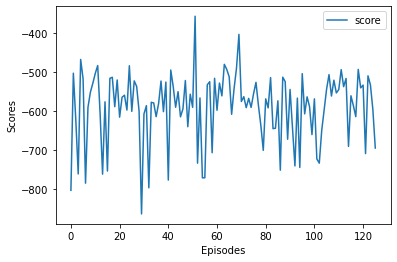

In [50]:
%matplotlib inline
plt.plot(np.arange(len(reward_per_ep)),reward_per_ep,label='score')
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.legend()
plt.show()

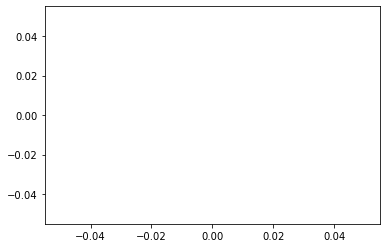

In [51]:
plt.plot(np.arange(len(reward_per_ep[500:])),reward_per_ep[500:],label='score')
plt.show()

In [57]:
score  = 0
state = env.reset()
while True:
    dist = actor(state)
    action = dist.sample().cpu().detach().numpy()[0]
    action = np.clip(action,-1,1)
    env.render()
    state,reward,done,_ = env.step(action)
    score+=reward
    if done:
        break
print("Score  : ",score)

Score  :  -1240.4406902209992
